In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use('seaborn-whitegrid')

device = "cuda" if torch.cuda.is_available() else "cpu"

In [37]:
class MultiRBFnn2(nn.Module):
    def __init__(self, in_feature, add_rbf_num, device):
        super(MultiRBFnn2, self).__init__()

        self.add_rbf_num = add_rbf_num  # additional RBFs number
        self.in_feature = in_feature    # count features
        self.device = device
        self.centers_list = []
        self.sigmas_list = []
        self.weights_list = []

        self.change_th = 3

    def first_rbf_parameter(self, input_data, target): 

        # input_data shape : (data_num)
        # target data shape : (in_feature, data_num)
        
        # first layer centers, weights, sigmas
        # centers, sigmas : (add_rbf_num, 1)
        # weights : (in_feature, add_rbf_num)

        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()

        find_sigma = target.clone().detach()
        find_weight = target.clone().detach()
        center_index_list = []

        # first MultiRBFs initial centers and weights parameters
        for i in range(self.add_rbf_num):
            index_ = torch.argmax(torch.sum(torch.abs(fine_index_target), dim = 0)).cpu().detach().tolist()
            fine_index_target[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device= self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        initweight = torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)

        # first MultiRBFs initial sigmas parameters                
        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))

        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num, 1)


        return initcenter, initweight, initsigma
    
    def add_rbf_parameter(self, input_data, error):
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        center_index_list = []

        for i in range(self.add_rbf_num * (self.change_time + 1)):
            index_ = torch.argmax(torch.sum(torch.abs(find_index_error), dim = 0)).cpu().detach().tolist()

            find_index_error[:,index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=self.device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)
        print('a:', torch.index_select(find_weight, 1, center_index_list)[-self.add_rbf_num:])
        initweight = torch.index_select(find_weight, 1, center_index_list)[::,-self.add_rbf_num:].reshape(self.in_feature, self.add_rbf_num)


        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft = (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(torch.mean(dft[:,k]).reshape(1))
        initsigma = torch.cat(sigma_list)[-self.add_rbf_num:].reshape(self.add_rbf_num,1)

        return initcenter, initweight, initsigma
    
    def rbf_gaussian(self, input_data):
        out = torch.exp(-1 *(torch.pow((input_data - self.centers), 2)) / (torch.pow(self.sigma, 2)))

        return out

    def forward(self, input_data):
        R = self.rbf_gaussian(input_data)
        pred = torch.mm(self.weights, R)

        return R, pred

    def rbf_gaussian_derivative_centers(self, input_data): # done
        output = (2 * (input_data - self.centers) / (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)

    def rbf_gaussian_derivative_sigma(self, input_data): # done
        output = (2 * torch.pow((input_data - self.centers), 2) / (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (add_rbf_num, data_num)
    
    # FUNCTION GRADIENT
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.centers) / \
                  (torch.pow(self.sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.centers), 2) / \
                (torch.pow(self.sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)

    def L2_F(self, input_data):
        return -2 * (input_data - self.centers) / torch.pow(self.sigma, 2)
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.centers) / torch.pow(self.sigma,2)) * radial_output


    # Backpropagation and train

    def BP(self, input_data, target, R, pred, target_grad, pred_grad):
        #print(target.size(), pred.size(), input_data.size(-1))
        print(pred)
        L2_grad = -2 * (target - pred) 
        print(torch.mean(L2_grad))
        L2_G_grad = -2 * (target_grad - pred_grad)
        print(torch.mean(L2_G_grad))
        deltaWeight1 = torch.matmul(L2_grad, R.T)
        deltaweight2 = torch.matmul(self.L2_2_derivateive_weight(input_data, R), L2_G_grad.T).T
        deltaWeight = deltaWeight1 + deltaweight2

        deltaCenter1 = (torch.matmul(L2_grad, self.rbf_gaussian_derivative_centers(input_data).T) * self.weights).T
        deltaCenter2 =  torch.matmul(L2_G_grad, (self.weights.T * self.L2_F(input_data) *
                                                  self.rbf_gaussian_derivative_centers(input_data)).T).T
        deltaCenter = deltaCenter1 + deltaCenter2

        deltaSigma1 = (torch.matmul(L2_grad, self.rbf_gaussian_derivative_sigma(input_data).T) * self.weights).T
        deltaSigma2 = torch.matmul(L2_G_grad, (self.weights.T * self.L2_F(input_data) *
                                                  self.rbf_gaussian_derivative_sigma(input_data)).T).T
        deltaSigma = deltaSigma1 + deltaSigma2

        print('deltasigma1')
        print(deltaSigma1)
        print('--------------------')
        print('deltasigma2')
        print(deltaSigma2)
        print('--------------------')
        print('deltasigma')
        print(deltaSigma)
        print('--------------------')
        
        print('deltacenter1')
        print(deltaCenter1)
        print('--------------------')
        print('deltacenter2')
        print(deltaCenter2)
        print('--------------------')
        print('deltacenter')
        print(deltaCenter)
        print('--------------------')

        print('deltaweight1')
        print(deltaWeight1)
        print('--------------------')
        print('deltaweight2')
        print(deltaweight2)
        print('--------------------')
        print('deltaweight')
        print(deltaWeight)
        print('--------------------')

        self.centers -= self.lr * deltaCenter
        self.sigma -= self.lr * deltaSigma
        self.weights -= self.lr * deltaWeight

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1
    
    def plot_train(self, input_data, best_pred): #done
        if self.in_feature != 1:
            fig, ax = plt.subplots(1, self.in_feature, figsize = (30, 5))
            for i in range(self.in_feature):
                ax[i].plot(input_data.cpu().detach().numpy(), self.target[i].cpu().detach().numpy())
                ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
            plt.show()
        
        else:
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

    def best_forward(self, input_data, best_center, best_sigma, best_weight): # ?
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                        (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return pred
    
    def Loss(self, pred, target, pred_grad, true_grad):
        # value L2 loss  

        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2)) 
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr
        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.lr_change_th = lr_change_th
        self.change_time = 0

        break_time = len(input_data) / self.add_rbf_num

        loss = 100000
        
        while self.loss_th < loss:

            print("{}th additional rbflayer".format(self.number))
            # first rbflayer
            if self.number == 0:
                self.centers, self.weights, self.sigma = self.first_rbf_parameter(input_data, self.target)
                print('initial parameters')
                print(self.centers)
                print(self.weights)
                print(self.sigma)
                print('----------------------')
                first_grad = self.first_grad(input_data, target)
                for epoch in range(epochs):
                    print("epoch : {}".format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)

                    self.BP(input_data, self.target, R, pred, first_grad, rbf_grad)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, first_grad)

                    if epoch == 0:
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch, epoch_loss))
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                    
                    else:
                        if self.best_loss > epoch_loss:
                            self.best_loss = epoch_loss.clone().detach()
                            self.best_center = self.centers.clone().detach()
                            self.best_sigma = self.sigma.clone().detach()
                            self.best_weight = self.weights.clone().detach()

                    if (epoch + 1) % 250 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))

            else:
                self.change_init(na)
                if self.change_time > break_time:
                    break
                
                
                self.centers, self.weights, self.sigma = self.add_rbf_parameter(input_data, self.target)
                print('additional parameters')
                print(self.centers)
                print(self.weights)
                print(self.sigma)
                print('----------------------')
                for epoch in range(epochs):
                    print('epoch : {}'.format(epoch))
                    R, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.centers, self.sigma, self.weights)
                    if epoch == 0:
                        
                        print("{}th additional RBFlayer {}th epoch loss: {}".format(self.number, epoch,
                                                                                        self.Loss(pred, self.target, rbf_grad, target_grad)))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()

                    self.BP(input_data, self.target, R, pred, target_grad, rbf_grad)
                    epoch_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epoch + 1) % 250 == 0:
                        print("{}th additional RBFlayer {}th epoch MSE Loss: {}".format(self.number, epoch, epoch_loss))
                    
                    if self.best_loss > epoch_loss:
                        self.best_loss = epoch_loss.clone().detach()
                        self.best_center = self.centers.clone().detach()
                        self.best_sigma = self.sigma.clone().detach()
                        self.best_weight = self.weights.clone().detach()
                
            best_pred = self.best_forward(input_data, self.best_center, self.best_sigma, self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print("{}th additional RBFlayer best loss : ".format(self.number, train_loss))

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')
                
            self.train_loss_list.append(train_loss)

            # additional rbf plot print
            self.plot_train(input_data, best_pred)

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.centers_list.append(self.best_center)
                self.sigmas_list.append(self.best_sigma)
                self.weights_list.append(self.best_weight)

                self.done_centers = torch.cat(self.centers_list, dim  =0)
                self.done_sigma = torch.cat(self.sigmas_list, dim = 0)
                self.done_weights = torch.cat(self.weights_list, dim = 1)
                target_grad = self.target_grad(input_data, self.done_centers, self.done_sigma, self.done_weights, first_grad)

            else:
                na = 0
    

In [3]:
import numpy as np
a = np.arange(0,10,0.05)
    
y = 2*a**3 - 16*a**2 + 2*a -10
y2 = 3*a**2 -16*a - 30
y3 = 5*a**2 +25*a - a**3

target = np.array((y,y2,y3))
target = torch.tensor(target, device = device).reshape((3,200))
input_ = torch.tensor(a, device = device)
single_target = torch.tensor(np.array(y), device = device, dtype=float).reshape(1,200)

In [5]:
def plot_data(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

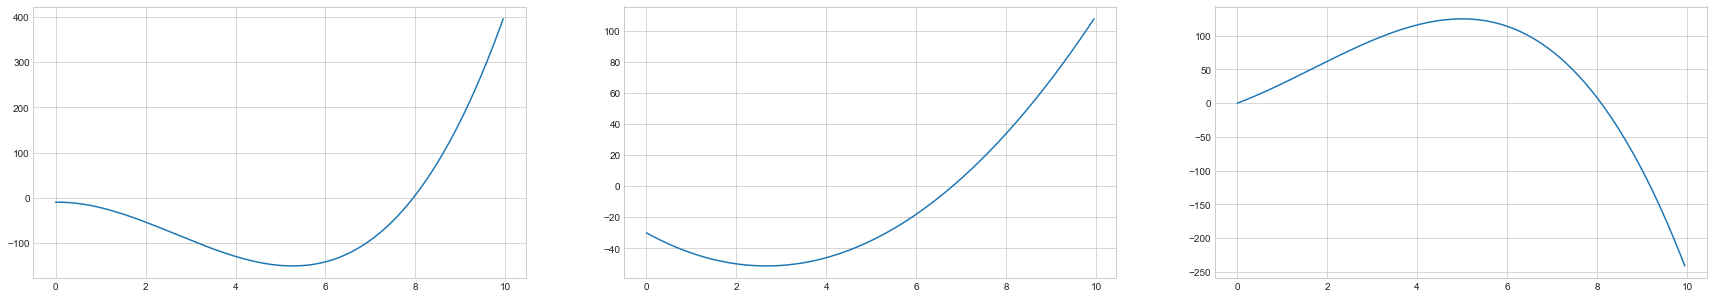

In [6]:
plot_data(input_, 3, target)

0th additional rbflayer
initial parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[396.0098, 382.2380, 368.6833, 355.3440, 342.2188]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0000],
        [1.1765],
        [1.3219],
        [1.4643],
        [1.6227]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
tensor([[7.1792e-14, 1.0387e-13, 1.4999e-13, 2.1617e-13, 3.1097e-13, 4.4651e-13,
         6.3989e-13, 9.1529e-13, 1.3067e-12, 1.8621e-12, 2.6484e-12, 3.7596e-12,
         5.3269e-12, 7.5333e-12, 1.0634e-11, 1.4981e-11, 2.1066e-11, 2.9567e-11,
         4.1419e-11, 5.7913e-11, 8.0822e-11, 1.1258e-10, 1.5652e-10, 2.1720e-10,
         3.0083e-10, 4.1587e-10, 5.7383e-10, 7.9028e-10, 1.0863e-09, 1.4904e-09,
         2.0410e-09, 2.7898e-09, 3.8060e-09, 5.1825e-09, 7.0436e-09, 9.5551e-09,
         1.2938e-08, 1.7484e-08, 2.3585e-08, 3.1754e-08, 4.2672e-08, 5.723

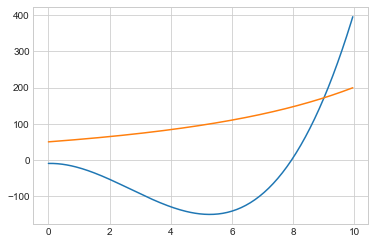

1th additional rbflayer
a: tensor([[-253.4695, -253.4344, -253.4198, -253.3131, -253.2867]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[5.7000],
        [5.7500],
        [5.6500],
        [5.8000],
        [5.6000]], device='cuda:0', dtype=torch.float64)
tensor([[-253.4695, -253.4344, -253.4198, -253.3131, -253.2867]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.0992],
        [2.0992],
        [2.0991],
        [2.0993],
        [2.0990]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
1th additional RBFlayer 0th epoch loss: 320137.9565989958
tensor([[-8.0780e-01, -9.1857e-01, -1.0433e+00, -1.1837e+00, -1.3415e+00,
         -1.5185e+00, -1.7170e+00, -1.9392e+00, -2.1877e+00, -2.4653e+00,
         -2.7749e+00, -3.1199e+00, -3.5038e+00, -3.9304e+00, -4.4041e+00,
         -4.9292e+00, -5.5107e+00, -6.1539e+00, -6.8643e+00, -7.6481e+00,
         -8.5117e+00, -9.4622e+00, -1.0507e+01, -1.1654e+01, -1.2911e+01,
         -

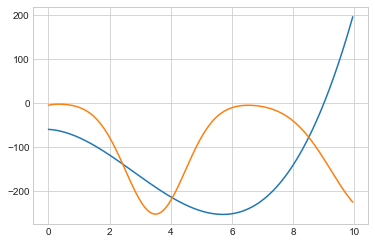

2th additional rbflayer
a: tensor([[422.1158, 405.8710, 389.6080, 373.3412, 357.0855]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[422.1158, 405.8710, 389.6080, 373.3412, 357.0855]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0000],
        [1.1483],
        [1.1177],
        [1.5384],
        [1.5170]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
2th additional RBFlayer 0th epoch loss: 367365.79738858924
tensor([[1.2957e-15, 1.9643e-15, 2.9715e-15, 4.4858e-15, 6.7575e-15, 1.0158e-14,
         1.5238e-14, 2.2810e-14, 3.4072e-14, 5.0787e-14, 7.5542e-14, 1.1213e-13,
         1.6608e-13, 2.4546e-13, 3.6203e-13, 5.3284e-13, 7.8256e-13, 1.1469e-12,
         1.6773e-12, 2.4478e-12, 3.5647e-12, 5.1803e-12, 7.5120e-12, 1.0870e-11,
         1.5697e-11, 2.2618e-11, 3.2523e-11, 4.6665e-11, 6.6815e-

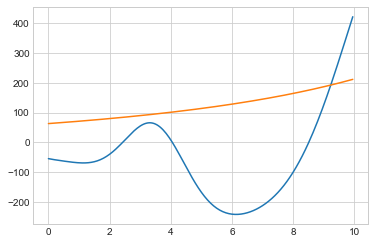

3th additional rbflayer
a: tensor([[-374.2511, -374.2369, -374.0742, -374.0269, -373.7101]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[6.3500],
        [6.3000],
        [6.4000],
        [6.2500],
        [6.4500]], device='cuda:0', dtype=torch.float64)
tensor([[-374.2511, -374.2369, -374.0742, -374.0269, -373.7101]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.0400],
        [2.0399],
        [2.0402],
        [2.0397],
        [2.0404]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
3th additional RBFlayer 0th epoch loss: 689521.4163853988
tensor([[-1.1844e-01, -1.3783e-01, -1.6020e-01, -1.8598e-01, -2.1566e-01,
         -2.4977e-01, -2.8892e-01, -3.3382e-01, -3.8523e-01, -4.4402e-01,
         -5.1117e-01, -5.8778e-01, -6.7505e-01, -7.7435e-01, -8.8720e-01,
         -1.0153e+00, -1.1605e+00, -1.3248e+00, -1.5106e+00, -1.7204e+00,
         -1.9570e+00, -2.2235e+00, -2.5232e+00, -2.8599e+00, -3.2376e+00,
         -

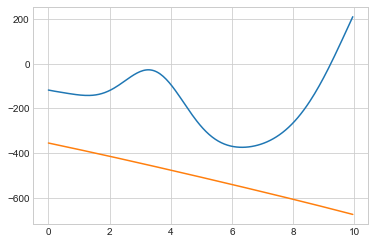

4th additional rbflayer
a: tensor([[885.3070, 868.6752, 852.0175, 835.3485, 818.6829, 802.0361, 785.4237,
         768.8616, 752.3658, 735.9521]], device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[9.7000],
        [9.6500],
        [9.6000],
        [9.5500],
        [9.5000]], device='cuda:0', dtype=torch.float64)
tensor([[802.0361, 785.4237, 768.8616, 752.3658, 735.9521]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.2267],
        [4.8894],
        [2.6213],
        [2.3055],
        [2.1819]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
4th additional RBFlayer 0th epoch loss: 2353713.8055825196
tensor([[  15.9743,   16.6307,   17.3105,   18.0142,   18.7428,   19.4967,
           20.2767,   21.0835,   21.9179,   22.7806,   23.6723,   24.5939,
           25.5460,   26.5294,   27.5451,   28.5937,   29.6761,   30.7931,
           31.9456,   33.1344,   34.3604,   35.6244,   36.9274,   38.2702,
           39.6537,   41.0789,   42.5

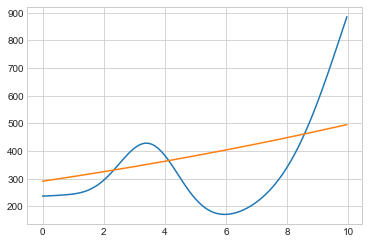

5th additional rbflayer
a: tensor([[389.7992, 374.4161, 359.0048, 343.5797, 328.1558]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[389.7992, 374.4161, 359.0048, 343.5797, 328.1558]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0000],
        [1.1473],
        [1.1088],
        [1.5559],
        [1.5156]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
5th additional RBFlayer 0th epoch loss: 314818.04207242874
tensor([[2.3716e-15, 3.5618e-15, 5.3384e-15, 7.9849e-15, 1.1919e-14, 1.7756e-14,
         2.6397e-14, 3.9164e-14, 5.7987e-14, 8.5682e-14, 1.2635e-13, 1.8593e-13,
         2.7306e-13, 4.0021e-13, 5.8537e-13, 8.5444e-13, 1.2447e-12, 1.8094e-12,
         2.6250e-12, 3.8006e-12, 5.4914e-12, 7.9181e-12, 1.1394e-11, 1.6363e-11,
         2.3450e-11, 3.3538e-11, 4.7868e-11, 6.8183e-11, 9.6920e-

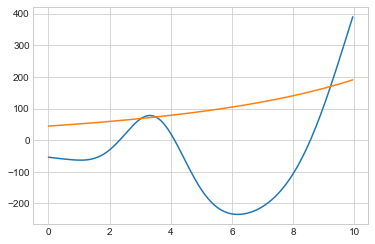

6th additional rbflayer
a: tensor([[-343.4152, -343.3422, -343.3086, -343.0856, -343.0258]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[6.4000],
        [6.3500],
        [6.4500],
        [6.3000],
        [6.5000]], device='cuda:0', dtype=torch.float64)
tensor([[-343.4152, -343.3422, -343.3086, -343.0856, -343.0258]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.0486],
        [2.0484],
        [2.0488],
        [2.0483],
        [2.0490]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
6th additional RBFlayer 0th epoch loss: 582227.467759096
tensor([[-1.0123e-01, -1.1780e-01, -1.3691e-01, -1.5894e-01, -1.8429e-01,
         -2.1343e-01, -2.4688e-01, -2.8524e-01, -3.2917e-01, -3.7941e-01,
         -4.3679e-01, -5.0226e-01, -5.7686e-01, -6.6175e-01, -7.5823e-01,
         -8.6774e-01, -9.9189e-01, -1.1325e+00, -1.2914e+00, -1.4709e+00,
         -1.6734e+00, -1.9015e+00, -2.1581e+00, -2.4464e+00, -2.7700e+00,
         -3

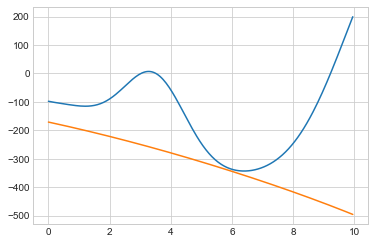

7th additional rbflayer
a: tensor([[695.4068, 679.3938, 663.3460, 647.2777, 631.2040, 615.1401, 599.1018,
         583.1050, 567.1657, 551.3000]], device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[9.7000],
        [9.6500],
        [9.6000],
        [9.5500],
        [9.5000]], device='cuda:0', dtype=torch.float64)
tensor([[615.1401, 599.1018, 583.1050, 567.1657, 551.3000]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.1065],
        [4.6770],
        [2.4856],
        [2.1836],
        [2.0655]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
7th additional RBFlayer 0th epoch loss: 1366777.5193790963
tensor([[   8.4843,    8.8660,    9.2628,    9.6750,   10.1034,   10.5483,
           11.0102,   11.4898,   11.9876,   12.5040,   13.0397,   13.5953,
           14.1713,   14.7684,   15.3871,   16.0281,   16.6920,   17.3795,
           18.0911,   18.8277,   19.5897,   20.3780,   21.1932,   22.0361,
           22.9073,   23.8075,   24.7

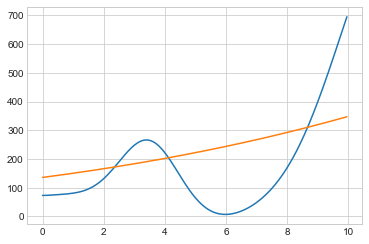

8th additional rbflayer
a: tensor([[348.2974, 333.7706, 319.2041, 304.6123, 290.0101]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[348.2974, 333.7706, 319.2041, 304.6123, 290.0101]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0227],
        [1.1725],
        [1.1251],
        [1.6117],
        [1.5483]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
8th additional RBFlayer 0th epoch loss: 258109.54708787825
tensor([[2.8493e-14, 4.1586e-14, 6.0582e-14, 8.8088e-14, 1.2784e-13, 1.8519e-13,
         2.6775e-13, 3.8640e-13, 5.5657e-13, 8.0018e-13, 1.1483e-12, 1.6447e-12,
         2.3512e-12, 3.3550e-12, 4.7784e-12, 6.7929e-12, 9.6384e-12, 1.3650e-11,
         1.9296e-11, 2.7225e-11, 3.8341e-11, 5.3893e-11, 7.5612e-11, 1.0589e-10,
         1.4800e-10, 2.0648e-10, 2.8752e-10, 3.9963e-10, 5.5440e-

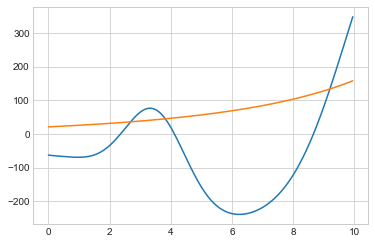

9th additional rbflayer
a: tensor([[-312.7880, -312.7350, -312.6727, -312.5103, -312.3920]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[6.4500],
        [6.4000],
        [6.5000],
        [6.3500],
        [6.5500]], device='cuda:0', dtype=torch.float64)
tensor([[-312.7880, -312.7350, -312.6727, -312.5103, -312.3920]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.0475],
        [2.0473],
        [2.0477],
        [2.0471],
        [2.0479]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
9th additional RBFlayer 0th epoch loss: 483527.05767106265
tensor([[-7.8295e-02, -9.1230e-02, -1.0618e-01, -1.2343e-01, -1.4330e-01,
         -1.6619e-01, -1.9250e-01, -2.2270e-01, -2.5735e-01, -2.9702e-01,
         -3.4241e-01, -3.9426e-01, -4.5342e-01, -5.2085e-01, -5.9758e-01,
         -6.8481e-01, -7.8383e-01, -8.9611e-01, -1.0233e+00, -1.1670e+00,
         -1.3295e+00, -1.5127e+00, -1.7191e+00, -1.9513e+00, -2.2123e+00,
         

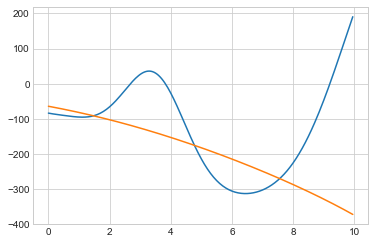

10th additional rbflayer
a: tensor([[562.5708, 547.3918, 532.1656, 516.9066, 501.6298]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[562.5708, 547.3918, 532.1656, 516.9066, 501.6298]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0477],
        [1.2059],
        [1.1563],
        [1.7411],
        [1.6497]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
10th additional RBFlayer 0th epoch loss: 657918.6512078089
tensor([[9.3355e-12, 1.2904e-11, 1.7809e-11, 2.4538e-11, 3.3756e-11, 4.6361e-11,
         6.3571e-11, 8.7030e-11, 1.1895e-10, 1.6232e-10, 2.2115e-10, 3.0082e-10,
         4.0853e-10, 5.5392e-10, 7.4984e-10, 1.0134e-09, 1.3675e-09, 1.8423e-09,
         2.4780e-09, 3.3276e-09, 4.4615e-09, 5.9722e-09, 7.9816e-09, 1.0650e-08,
         1.4188e-08, 1.8871e-08, 2.5060e-08, 3.3225e-08, 4.3980e

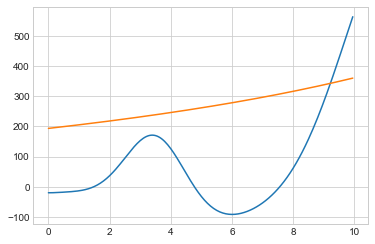

11th additional rbflayer
a: tensor([[-371.0533, -371.0051, -370.9055, -370.7672, -370.5546]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[6.2000],
        [6.2500],
        [6.1500],
        [6.3000],
        [6.1000]], device='cuda:0', dtype=torch.float64)
tensor([[-371.0533, -371.0051, -370.9055, -370.7672, -370.5546]],
       device='cuda:0', dtype=torch.float64)
tensor([[1.9760],
        [1.9761],
        [1.9759],
        [1.9762],
        [1.9758]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
11th additional RBFlayer 0th epoch loss: 674407.994203889
tensor([[-1.0066e-01, -1.1786e-01, -1.3782e-01, -1.6096e-01, -1.8774e-01,
         -2.1870e-01, -2.5444e-01, -2.9564e-01, -3.4308e-01, -3.9762e-01,
         -4.6024e-01, -5.3204e-01, -6.1427e-01, -7.0829e-01, -8.1566e-01,
         -9.3811e-01, -1.0776e+00, -1.2362e+00, -1.4163e+00, -1.6206e+00,
         -1.8520e+00, -2.1138e+00, -2.4095e+00, -2.7431e+00, -3.1188e+00,
         

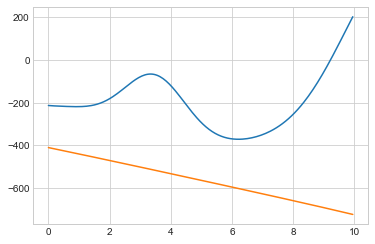

12th additional rbflayer
a: tensor([[926.1788, 910.5158, 894.8032, 879.0556, 863.2878, 847.5153, 831.7538,
         816.0192, 800.3276, 784.6951]], device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[9.7000],
        [9.6500],
        [9.6000],
        [9.5500],
        [9.5000]], device='cuda:0', dtype=torch.float64)
tensor([[847.5153, 831.7538, 816.0192, 800.3276, 784.6951]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.7866],
        [2.6511],
        [2.2712],
        [2.1407],
        [2.0734]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
12th additional RBFlayer 0th epoch loss: 2477494.5093596336
tensor([[6.1141e-03, 6.9473e-03, 7.8891e-03, 8.9530e-03, 1.0154e-02, 1.1509e-02,
         1.3037e-02, 1.4758e-02, 1.6697e-02, 1.8878e-02, 2.1331e-02, 2.4087e-02,
         2.7183e-02, 3.0659e-02, 3.4557e-02, 3.8926e-02, 4.3822e-02, 4.9302e-02,
         5.5434e-02, 6.2290e-02, 6.9951e-02, 7.8506e-02, 8.8054e-02, 9.8702e-02,
         1.

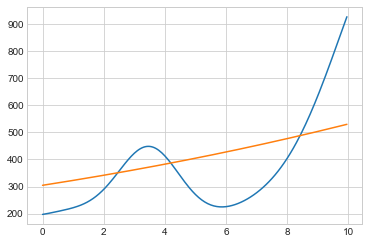

13th additional rbflayer
a: tensor([[396.7279, 382.4723, 368.1640, 353.8176, 339.4480]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[396.7279, 382.4723, 368.1640, 353.8176, 339.4480]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0000],
        [1.1479],
        [1.0922],
        [1.6697],
        [1.5547]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
13th additional RBFlayer 0th epoch loss: 325361.35125908686
tensor([[3.9031e-13, 5.5442e-13, 7.8615e-13, 1.1128e-12, 1.5723e-12, 2.2176e-12,
         3.1222e-12, 4.3881e-12, 6.1563e-12, 8.6218e-12, 1.2053e-11, 1.6821e-11,
         2.3433e-11, 3.2586e-11, 4.5234e-11, 6.2681e-11, 8.6705e-11, 1.1972e-10,
         1.6503e-10, 2.2708e-10, 3.1190e-10, 4.2766e-10, 5.8536e-10, 7.9980e-10,
         1.0909e-09, 1.4853e-09, 2.0187e-09, 2.7390e-09, 3.7097

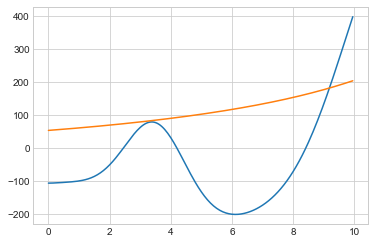

14th additional rbflayer
a: tensor([[-321.4086, -321.4025, -321.2440, -321.2207, -320.9130]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[6.3500],
        [6.3000],
        [6.4000],
        [6.2500],
        [6.4500]], device='cuda:0', dtype=torch.float64)
tensor([[-321.4086, -321.4025, -321.2440, -321.2207, -320.9130]],
       device='cuda:0', dtype=torch.float64)
tensor([[1.9856],
        [1.9855],
        [1.9857],
        [1.9854],
        [1.9859]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
14th additional RBFlayer 0th epoch loss: 504163.03552149894
tensor([[-5.9528e-02, -6.9859e-02, -8.1879e-02, -9.5846e-02, -1.1205e-01,
         -1.3084e-01, -1.5257e-01, -1.7770e-01, -2.0670e-01, -2.4013e-01,
         -2.7861e-01, -3.2285e-01, -3.7364e-01, -4.3188e-01, -4.9856e-01,
         -5.7482e-01, -6.6189e-01, -7.6119e-01, -8.7429e-01, -1.0029e+00,
         -1.1490e+00, -1.3147e+00, -1.5024e+00, -1.7148e+00, -1.9547e+00,
       

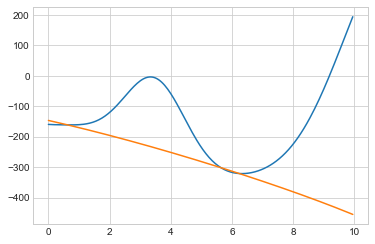

15th additional rbflayer
a: tensor([[649.5501, 634.7829, 619.9576, 605.0887, 590.1912, 575.2805, 560.3722,
         545.4824, 530.6271, 515.8223]], device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[9.7000],
        [9.6500],
        [9.6000],
        [9.5500],
        [9.5000]], device='cuda:0', dtype=torch.float64)
tensor([[575.2805, 560.3722, 545.4824, 530.6271, 515.8223]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.4371],
        [2.5909],
        [2.1425],
        [2.0044],
        [1.9352]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
15th additional RBFlayer 0th epoch loss: 1105441.69747001
tensor([[6.0609e-04, 7.0135e-04, 8.1101e-04, 9.3715e-04, 1.0822e-03, 1.2487e-03,
         1.4399e-03, 1.6591e-03, 1.9104e-03, 2.1983e-03, 2.5277e-03, 2.9044e-03,
         3.3349e-03, 3.8266e-03, 4.3877e-03, 5.0275e-03, 5.7566e-03, 6.5868e-03,
         7.5314e-03, 8.6056e-03, 9.8261e-03, 1.1212e-02, 1.2784e-02, 1.4567e-02,
         1.65

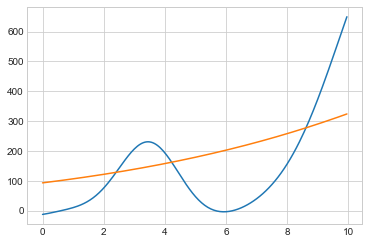

16th additional rbflayer
a: tensor([[325.8544, 312.9328, 299.9445, 286.9041, 273.8264]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[325.8544, 312.9328, 299.9445, 286.9041, 273.8264]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0449],
        [1.1955],
        [1.1212],
        [1.8109],
        [1.6106]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
16th additional RBFlayer 0th epoch loss: 229944.33339841047
tensor([[5.4911e-11, 7.3982e-11, 9.9525e-11, 1.3368e-10, 1.7930e-10, 2.4010e-10,
         3.2104e-10, 4.2862e-10, 5.7137e-10, 7.6051e-10, 1.0107e-09, 1.3412e-09,
         1.7771e-09, 2.3510e-09, 3.1056e-09, 4.0962e-09, 5.3946e-09, 7.0937e-09,
         9.3139e-09, 1.2211e-08, 1.5984e-08, 2.0891e-08, 2.7264e-08, 3.5527e-08,
         4.6225e-08, 6.0053e-08, 7.7901e-08, 1.0090e-07, 1.3049

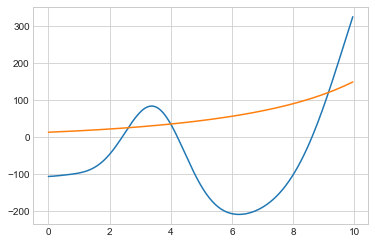

17th additional rbflayer
a: tensor([[-269.7300, -269.6781, -269.6310, -269.4715, -269.3838]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[6.4500],
        [6.4000],
        [6.5000],
        [6.3500],
        [6.5500]], device='cuda:0', dtype=torch.float64)
tensor([[-269.7300, -269.6781, -269.6310, -269.4715, -269.3838]],
       device='cuda:0', dtype=torch.float64)
tensor([[1.9882],
        [1.9881],
        [1.9884],
        [1.9880],
        [1.9885]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
17th additional RBFlayer 0th epoch loss: 355689.20620595827
tensor([[-3.7141e-02, -4.3678e-02, -5.1302e-02, -6.0180e-02, -7.0505e-02,
         -8.2498e-02, -9.6409e-02, -1.1252e-01, -1.3117e-01, -1.5271e-01,
         -1.7756e-01, -2.0619e-01, -2.3914e-01, -2.7701e-01, -3.2047e-01,
         -3.7028e-01, -4.2729e-01, -4.9246e-01, -5.6685e-01, -6.5166e-01,
         -7.4821e-01, -8.5798e-01, -9.8261e-01, -1.1239e+00, -1.2840e+00,
       

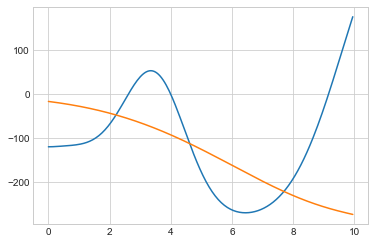

18th additional rbflayer
a: tensor([[449.7562, 438.0488, 426.2336, 414.3245, 402.3360]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[449.7562, 438.0488, 426.2336, 414.3245, 402.3360]], device='cuda:0',
       dtype=torch.float64)
tensor([[ 1.0000],
        [ 1.1674],
        [ 1.0710],
        [13.1432],
        [ 1.6788]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
18th additional RBFlayer 0th epoch loss: 509836.09537281696
tensor([[ 237.6213,  238.9698,  240.3189,  241.6687,  243.0190,  244.3697,
          245.7209,  247.0724,  248.4241,  249.7760,  251.1280,  252.4800,
          253.8319,  255.1837,  256.5353,  257.8865,  259.2374,  260.5878,
          261.9376,  263.2868,  264.6354,  265.9831,  267.3299,  268.6758,
          270.0206,  271.3644,  272.7069,  274.0481,  275.3880,  276.7263,
       

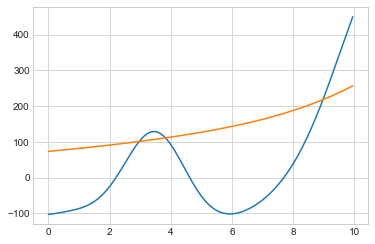

19th additional rbflayer
a: tensor([[-245.6157, -245.5725, -245.4852, -245.3635, -245.1726]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[6.1500],
        [6.2000],
        [6.1000],
        [6.2500],
        [6.0500]], device='cuda:0', dtype=torch.float64)
tensor([[-245.6157, -245.5725, -245.4852, -245.3635, -245.1726]],
       device='cuda:0', dtype=torch.float64)
tensor([[1.9130],
        [1.9131],
        [1.9129],
        [1.9131],
        [1.9129]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
19th additional RBFlayer 0th epoch loss: 297385.51213722036
tensor([[-4.0917e-02, -4.8350e-02, -5.7056e-02, -6.7237e-02, -7.9127e-02,
         -9.2994e-02, -1.0914e-01, -1.2792e-01, -1.4972e-01, -1.7500e-01,
         -2.0427e-01, -2.3811e-01, -2.7718e-01, -3.2222e-01, -3.7407e-01,
         -4.3367e-01, -5.0208e-01, -5.8050e-01, -6.7024e-01, -7.7281e-01,
         -8.8986e-01, -1.0232e+00, -1.1750e+00, -1.3475e+00, -1.5431e+00,
       

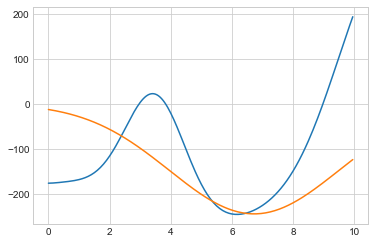

20th additional rbflayer
a: tensor([[317.1444, 310.2557, 303.2471, 296.1313, 288.9213]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[317.1444, 310.2557, 303.2471, 296.1313, 288.9213]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.2454],
        [1.4524],
        [1.1171],
        [1.5828],
        [3.2703]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
20th additional RBFlayer 0th epoch loss: 230564.99478342183
tensor([[3.9856e-02, 4.3650e-02, 4.7783e-02, 5.2283e-02, 5.7180e-02, 6.2506e-02,
         6.8296e-02, 7.4588e-02, 8.1422e-02, 8.8840e-02, 9.6888e-02, 1.0562e-01,
         1.1508e-01, 1.2533e-01, 1.3643e-01, 1.4844e-01, 1.6143e-01, 1.7548e-01,
         1.9067e-01, 2.0707e-01, 2.2477e-01, 2.4388e-01, 2.6448e-01, 2.8670e-01,
         3.1063e-01, 3.3641e-01, 3.6415e-01, 3.9399e-01, 4.2609

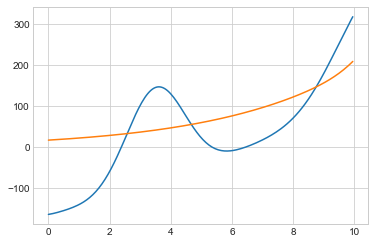

21th additional rbflayer
a: tensor([[-180.6862, -180.2800, -179.7823, -179.2075, -178.5678]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[0.0000],
        [0.0500],
        [0.1000],
        [0.1500],
        [0.2000]], device='cuda:0', dtype=torch.float64)
tensor([[-180.6862, -180.2800, -179.7823, -179.2075, -178.5678]],
       device='cuda:0', dtype=torch.float64)
tensor([[1.0000],
        [1.1074],
        [2.0807],
        [1.1305],
        [1.4997]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
21th additional RBFlayer 0th epoch loss: 77790.17204776792
tensor([[-8.9147e+02, -8.9479e+02, -8.9522e+02, -8.9274e+02, -8.8740e+02,
         -8.7926e+02, -8.6844e+02, -8.5506e+02, -8.3927e+02, -8.2126e+02,
         -8.0121e+02, -7.7935e+02, -7.5588e+02, -7.3106e+02, -7.0510e+02,
         -6.7823e+02, -6.5070e+02, -6.2272e+02, -5.9450e+02, -5.6623e+02,
         -5.3812e+02, -5.1031e+02, -4.8297e+02, -4.5623e+02, -4.3019e+02,
        

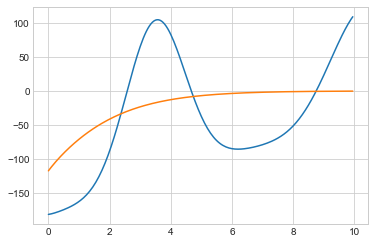

22th additional rbflayer
a: tensor([[120.9694, 120.9107, 120.4073, 120.2293, 119.2315]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[3.5500],
        [3.5000],
        [3.6000],
        [3.4500],
        [3.6500]], device='cuda:0', dtype=torch.float64)
tensor([[120.9694, 120.9107, 120.4073, 120.2293, 119.2315]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.8093],
        [1.8095],
        [1.8092],
        [1.8096],
        [1.8091]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
22th additional RBFlayer 0th epoch loss: 87001.09691203955
tensor([[1.2948e+01, 1.4415e+01, 1.6024e+01, 1.7785e+01, 1.9710e+01, 2.1811e+01,
         2.4098e+01, 2.6584e+01, 2.9283e+01, 3.2206e+01, 3.5368e+01, 3.8780e+01,
         4.2458e+01, 4.6413e+01, 5.0659e+01, 5.5210e+01, 6.0078e+01, 6.5276e+01,
         7.0815e+01, 7.6708e+01, 8.2965e+01, 8.9596e+01, 9.6609e+01, 1.0401e+02,
         1.1181e+02, 1.2002e+02, 1.2863e+02, 1.3764e+02, 1.4707e

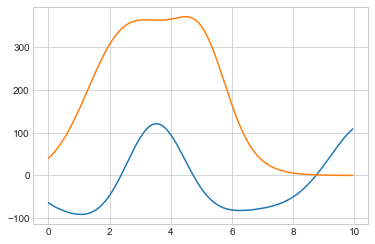

23th additional rbflayer
a: tensor([[-379.7095, -379.4687, -379.0628, -378.3303, -377.5490]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[5.0000],
        [5.0500],
        [4.9500],
        [5.1000],
        [4.9000]], device='cuda:0', dtype=torch.float64)
tensor([[-379.7095, -379.4687, -379.0628, -378.3303, -377.5490]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.2665],
        [2.2665],
        [2.2665],
        [2.2665],
        [2.2665]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
23th additional RBFlayer 0th epoch loss: 836090.9676327033
tensor([[  -14.7085,   -16.2012,   -17.8280,   -19.5991,   -21.5252,   -23.6176,
           -25.8883,   -28.3498,   -31.0151,   -33.8981,   -37.0131,   -40.3751,
           -43.9998,   -47.9033,   -52.1024,   -56.6146,   -61.4579,   -66.6507,
           -72.2120,   -78.1615,   -84.5190,   -91.3048,   -98.5397,  -106.2446,
          -114.4408,  -123.1496,  -132.3924,  -142.190

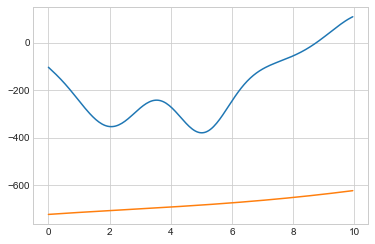

24th additional rbflayer
a: tensor([[732.0399, 729.6299, 726.9645, 724.0618, 720.9404, 717.6192, 714.1174,
         710.4543, 706.6492, 702.7211]], device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[9.7000],
        [9.6500],
        [9.6000],
        [9.5500],
        [9.5000]], device='cuda:0', dtype=torch.float64)
tensor([[717.6192, 714.1174, 710.4543, 706.6492, 702.7211]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.4971],
        [2.3589],
        [2.7179],
        [2.9973],
        [3.5092]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
24th additional RBFlayer 0th epoch loss: 1892822.262050459
tensor([[4.9183e-01, 5.3223e-01, 5.7574e-01, 6.2258e-01, 6.7301e-01, 7.2726e-01,
         7.8561e-01, 8.4836e-01, 9.1579e-01, 9.8825e-01, 1.0661e+00, 1.1496e+00,
         1.2393e+00, 1.3355e+00, 1.4388e+00, 1.5494e+00, 1.6681e+00, 1.7952e+00,
         1.9313e+00, 2.0771e+00, 2.2332e+00, 2.4002e+00, 2.5788e+00, 2.7698e+00,
         2.9

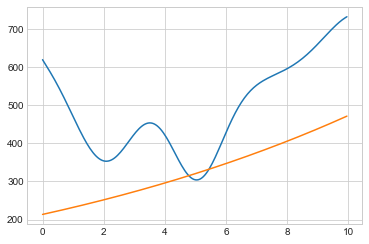

25th additional rbflayer
a: tensor([[405.9750, 398.6697, 391.3374, 383.9450, 376.4642]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[0.0000],
        [0.0500],
        [0.1000],
        [0.1500],
        [0.2000]], device='cuda:0', dtype=torch.float64)
tensor([[405.9750, 398.6697, 391.3374, 383.9450, 376.4642]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.0000],
        [1.1180],
        [1.9015],
        [1.1974],
        [1.5444]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
25th additional RBFlayer 0th epoch loss: 370386.13350211957
tensor([[1.9423e+03, 1.9489e+03, 1.9493e+03, 1.9435e+03, 1.9316e+03, 1.9137e+03,
         1.8901e+03, 1.8611e+03, 1.8269e+03, 1.7879e+03, 1.7446e+03, 1.6974e+03,
         1.6468e+03, 1.5932e+03, 1.5372e+03, 1.4792e+03, 1.4197e+03, 1.3591e+03,
         1.2980e+03, 1.2367e+03, 1.1756e+03, 1.1151e+03, 1.0555e+03, 9.9709e+02,
         9.4009e+02, 8.8474e+02, 8.3120e+02, 7.7963e+02, 7.3011

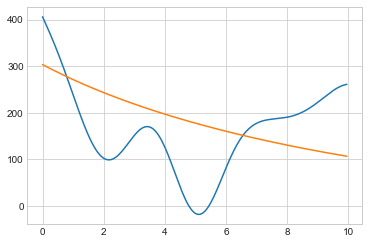

26th additional rbflayer
a: tensor([[-194.4147, -194.0897, -193.8540, -192.8799, -192.4178]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[5.0500],
        [5.1000],
        [5.0000],
        [5.1500],
        [4.9500]], device='cuda:0', dtype=torch.float64)
tensor([[-194.4147, -194.0897, -193.8540, -192.8799, -192.4178]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.8567],
        [2.8567],
        [2.8567],
        [2.8568],
        [2.8567]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
26th additional RBFlayer 0th epoch loss: 309671.8652321972
tensor([[ -42.6478,  -45.3531,  -48.2004,  -51.1951,  -54.3427,  -57.6484,
          -61.1179,  -64.7565,  -68.5697,  -72.5631,  -76.7421,  -81.1121,
          -85.6785,  -90.4466,  -95.4216, -100.6088, -106.0130, -111.6391,
         -117.4919, -123.5759, -129.8954, -136.4546, -143.2573, -150.3071,
         -157.6073, -165.1611, -172.9709, -181.0393, -189.3681, -197.9589,
   

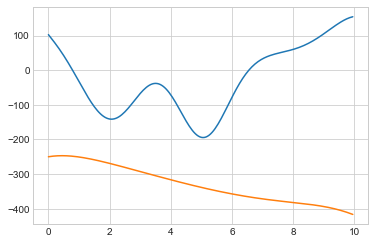

27th additional rbflayer
a: tensor([[570.7422, 567.9125, 564.8749, 561.6472, 558.2474]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[570.7422, 567.9125, 564.8749, 561.6472, 558.2474]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.2138],
        [4.1206],
        [1.2739],
        [1.6079],
        [1.7869]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
27th additional RBFlayer 0th epoch loss: 777769.436907509
tensor([[1.7675e+00, 1.8734e+00, 1.9850e+00, 2.1026e+00, 2.2265e+00, 2.3571e+00,
         2.4946e+00, 2.6393e+00, 2.7916e+00, 2.9518e+00, 3.1203e+00, 3.2974e+00,
         3.4836e+00, 3.6792e+00, 3.8846e+00, 4.1003e+00, 4.3267e+00, 4.5642e+00,
         4.8134e+00, 5.0746e+00, 5.3485e+00, 5.6355e+00, 5.9362e+00, 6.2510e+00,
         6.5807e+00, 6.9256e+00, 7.2865e+00, 7.6640e+00, 8.0586e+

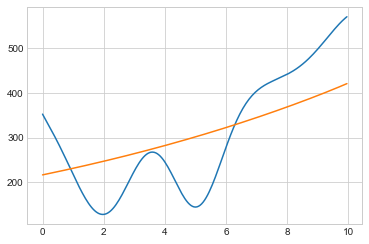

28th additional rbflayer
a: tensor([[-157.7643, -157.4324, -157.2225, -156.2278, -155.8167]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[5.0500],
        [5.1000],
        [5.0000],
        [5.1500],
        [4.9500]], device='cuda:0', dtype=torch.float64)
tensor([[-157.7643, -157.4324, -157.2225, -156.2278, -155.8167]],
       device='cuda:0', dtype=torch.float64)
tensor([[5.3170],
        [5.3178],
        [5.3167],
        [5.3193],
        [5.3170]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
28th additional RBFlayer 0th epoch loss: 381700.5638666143
tensor([[-318.3695, -324.0760, -329.8264, -335.6195, -341.4540, -347.3285,
         -353.2417, -359.1920, -365.1780, -371.1981, -377.2508, -383.3344,
         -389.4473, -395.5877, -401.7539, -407.9441, -414.1565, -420.3892,
         -426.6402, -432.9076, -439.1895, -445.4838, -451.7884, -458.1013,
         -464.4202, -470.7431, -477.0678, -483.3920, -489.7134, -496.0298,
   

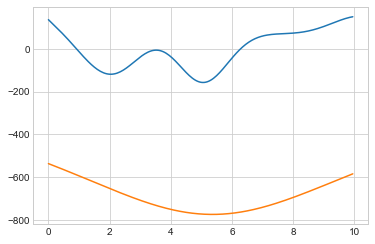

29th additional rbflayer
a: tensor([[801.2628, 801.1873, 801.0530, 800.8049, 800.5794]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[7.0000],
        [6.9500],
        [7.0500],
        [6.9000],
        [7.1000]], device='cuda:0', dtype=torch.float64)
tensor([[801.2628, 801.1873, 801.0530, 800.8049, 800.5794]], device='cuda:0',
       dtype=torch.float64)
tensor([[3.5123],
        [3.5116],
        [3.5131],
        [3.5109],
        [3.5139]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
29th additional RBFlayer 0th epoch loss: 4455932.340607833
tensor([[  75.6481,   80.0450,   84.6631,   89.5113,   94.5989,   99.9352,
          105.5298,  111.3924,  117.5331,  123.9621,  130.6898,  137.7268,
          145.0840,  152.7723,  160.8029,  169.1871,  177.9364,  187.0623,
          196.5766,  206.4913,  216.8181,  227.5692,  238.7567,  250.3928,
          262.4896,  275.0594,  288.1144,  301.6668,  315.7288,  330.3125,
          345

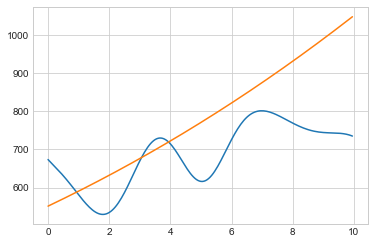

30th additional rbflayer
a: tensor([[-312.7612, -308.1346, -303.7283, -299.5244, -295.5048]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[9.9500],
        [9.9000],
        [9.8500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[-312.7612, -308.1346, -303.7283, -299.5244, -295.5048]],
       device='cuda:0', dtype=torch.float64)
tensor([[1.2760],
        [1.3367],
        [1.1518],
        [1.4066],
        [1.5861]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
30th additional RBFlayer 0th epoch loss: 228394.34569298878
tensor([[-1.1492e-14, -1.6915e-14, -2.4847e-14, -3.6428e-14, -5.3300e-14,
         -7.7831e-14, -1.1343e-13, -1.6497e-13, -2.3947e-13, -3.4692e-13,
         -5.0158e-13, -7.2376e-13, -1.0423e-12, -1.4980e-12, -2.1487e-12,
         -3.0758e-12, -4.3944e-12, -6.2658e-12, -8.9163e-12, -1.2663e-11,
         -1.7948e-11, -2.5389e-11, -3.5843e-11, -5.0501e-11, -7.1013e-11,
       

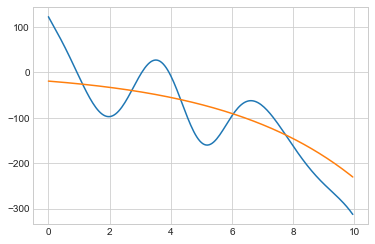

31th additional rbflayer
a: tensor([[141.5946, 135.7516, 129.9632, 124.1944, 118.4149]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[0.0000],
        [0.0500],
        [0.1000],
        [0.1500],
        [0.2000]], device='cuda:0', dtype=torch.float64)
tensor([[141.5946, 135.7516, 129.9632, 124.1944, 118.4149]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.2099],
        [1.6876],
        [1.2272],
        [1.0000],
        [1.2335]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
31th additional RBFlayer 0th epoch loss: 49600.13429124832
tensor([[6.4310e+02, 6.4649e+02, 6.4775e+02, 6.4687e+02, 6.4386e+02, 6.3875e+02,
         6.3158e+02, 6.2244e+02, 6.1141e+02, 5.9860e+02, 5.8415e+02, 5.6820e+02,
         5.5091e+02, 5.3243e+02, 5.1293e+02, 4.9260e+02, 4.7160e+02, 4.5012e+02,
         4.2830e+02, 4.0633e+02, 3.8435e+02, 3.6251e+02, 3.4094e+02, 3.1976e+02,
         2.9908e+02, 2.7899e+02, 2.5958e+02, 2.4090e+02, 2.2301e

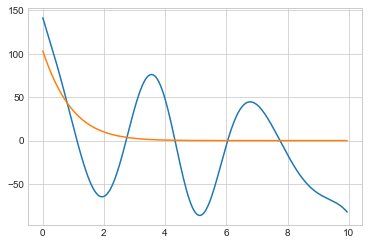

32th additional rbflayer
a: tensor([[-86.3410, -86.2604, -85.6224, -85.3690, -84.1264]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[5.1500],
        [5.1000],
        [5.2000],
        [5.0500],
        [5.2500]], device='cuda:0', dtype=torch.float64)
tensor([[-86.3410, -86.2604, -85.6224, -85.3690, -84.1264]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.0595],
        [2.0595],
        [2.0595],
        [2.0595],
        [2.0595]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
32th additional RBFlayer 0th epoch loss: 62424.78454040084
tensor([[  -0.8352,   -0.9421,   -1.0616,   -1.1948,   -1.3431,   -1.5080,
           -1.6912,   -1.8944,   -2.1196,   -2.3687,   -2.6440,   -2.9479,
           -3.2828,   -3.6514,   -4.0566,   -4.5016,   -4.9894,   -5.5237,
           -6.1079,   -6.7460,   -7.4420,   -8.2002,   -9.0250,   -9.9211,
          -10.8933,  -11.9467,  -13.0867,  -14.3185,  -15.6479,  -17.0806,
          -18

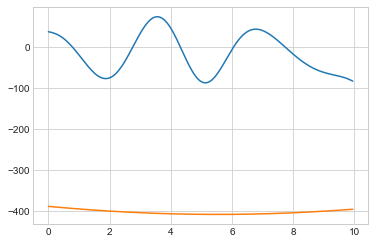

33th additional rbflayer
a: tensor([[480.3484, 480.2513, 479.7002, 479.4031, 478.3197]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[3.5500],
        [3.6000],
        [3.5000],
        [3.6500],
        [3.4500]], device='cuda:0', dtype=torch.float64)
tensor([[480.3484, 480.2513, 479.7002, 479.4031, 478.3197]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.7789],
        [2.7788],
        [2.7791],
        [2.7787],
        [2.7792]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
33th additional RBFlayer 0th epoch loss: 1494880.6662401368
tensor([[ 469.6086,  491.5121,  514.1047,  537.3882,  561.3632,  586.0286,
          611.3824,  637.4208,  664.1386,  691.5290,  719.5836,  748.2923,
          777.6434,  807.6234,  838.2170,  869.4071,  901.1750,  933.4998,
          966.3591,  999.7284, 1033.5814, 1067.8900, 1102.6242, 1137.7523,
         1173.2407, 1209.0540, 1245.1550, 1281.5051, 1318.0639, 1354.7893,
         139

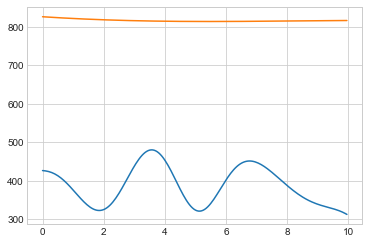

34th additional rbflayer
a: tensor([[-503.1399, -500.8844, -498.8206, -496.9310, -495.2293, -495.1978,
         -495.0993, -494.8296, -494.4584, -493.8862]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.7500],
        [1.8000],
        [1.9000],
        [1.7500],
        [1.9500]], device='cuda:0', dtype=torch.float64)
tensor([[-495.1978, -495.0993, -494.8296, -494.4584, -493.8862]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.1687],
        [2.8884],
        [2.8855],
        [2.8900],
        [2.8842]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
34th additional RBFlayer 0th epoch loss: 810942.4004495785
tensor([[-1311.8741, -1340.8701, -1369.6865, -1398.2845, -1426.6250, -1454.6685,
         -1482.3751, -1509.7050, -1536.6183, -1563.0749, -1589.0351, -1614.4592,
         -1639.3080, -1663.5427, -1687.1249, -1710.0169, -1732.1818, -1753.5834,
         -1774.1866, -1793.9570, -1812.8616, -1830.8685, -1847.9472, -1

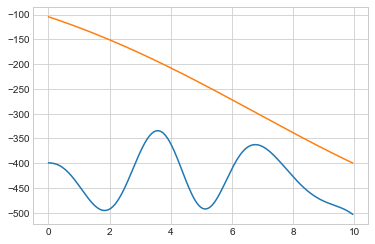

35th additional rbflayer
a: tensor([[-349.9924, -349.8605, -349.6558, -349.2337, -348.8802]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[1.7000],
        [1.7500],
        [1.6500],
        [1.8000],
        [1.6000]], device='cuda:0', dtype=torch.float64)
tensor([[-349.9924, -349.8605, -349.6558, -349.2337, -348.8802]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.3001],
        [2.3006],
        [2.2995],
        [2.3011],
        [2.2989]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
35th additional RBFlayer 0th epoch loss: 638243.7818200008
tensor([[-1.0121e+03, -1.0446e+03, -1.0771e+03, -1.1096e+03, -1.1420e+03,
         -1.1743e+03, -1.2063e+03, -1.2380e+03, -1.2693e+03, -1.3002e+03,
         -1.3306e+03, -1.3604e+03, -1.3896e+03, -1.4181e+03, -1.4458e+03,
         -1.4726e+03, -1.4985e+03, -1.5235e+03, -1.5474e+03, -1.5702e+03,
         -1.5918e+03, -1.6122e+03, -1.6313e+03, -1.6491e+03, -1.6655e+03,
        

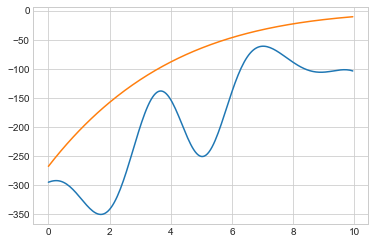

36th additional rbflayer
a: tensor([[-187.3817, -187.1289, -186.8118, -186.0521, -185.4309]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[5.1000],
        [5.0500],
        [5.1500],
        [5.0000],
        [5.2000]], device='cuda:0', dtype=torch.float64)
tensor([[-187.3817, -187.1289, -186.8118, -186.0521, -185.4309]],
       device='cuda:0', dtype=torch.float64)
tensor([[2.8028],
        [2.8028],
        [2.8028],
        [2.8028],
        [2.8027]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
36th additional RBFlayer 0th epoch loss: 267426.3901785457
tensor([[ -34.1516,  -36.4277,  -38.8309,  -41.3663,  -44.0392,  -46.8551,
          -49.8193,  -52.9374,  -56.2149,  -59.6574,  -63.2704,  -67.0597,
          -71.0307,  -75.1890,  -79.5402,  -84.0897,  -88.8430,  -93.8053,
          -98.9818, -104.3776, -109.9976, -115.8465, -121.9289, -128.2491,
         -134.8112, -141.6190, -148.6760, -155.9855, -163.5503, -171.3731,
   

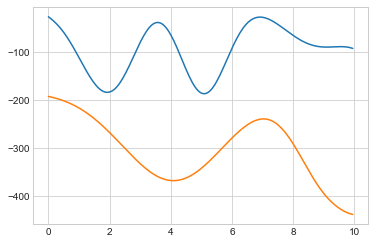

37th additional rbflayer
a: tensor([[345.6330, 345.5337, 345.3209, 345.0559, 344.2306]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[9.9000],
        [9.8500],
        [9.9500],
        [9.8000],
        [9.7500]], device='cuda:0', dtype=torch.float64)
tensor([[345.6330, 345.5337, 345.3209, 345.0559, 344.2306]], device='cuda:0',
       dtype=torch.float64)
tensor([[1.5080],
        [1.2542],
        [1.7759],
        [1.4417],
        [2.1072]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
37th additional RBFlayer 0th epoch loss: 318980.05647859955
tensor([[1.7339e-07, 2.1585e-07, 2.6840e-07, 3.3336e-07, 4.1359e-07, 5.1255e-07,
         6.3447e-07, 7.8451e-07, 9.6894e-07, 1.1954e-06, 1.4731e-06, 1.8133e-06,
         2.2295e-06, 2.7382e-06, 3.3591e-06, 4.1163e-06, 5.0384e-06, 6.1602e-06,
         7.5233e-06, 9.1777e-06, 1.1183e-05, 1.3612e-05, 1.6549e-05, 2.0098e-05,
         2.4380e-05, 2.9542e-05, 3.5756e-05, 4.3228e-05, 5.2203

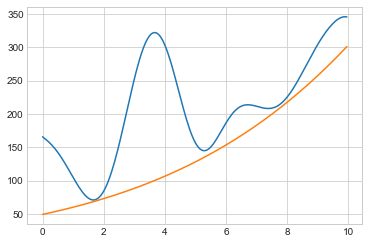

38th additional rbflayer
a: tensor([[222.1884, 221.9608, 221.5338, 220.8478, 220.0074]], device='cuda:0',
       dtype=torch.float64)
additional parameters
tensor([[3.6000],
        [3.6500],
        [3.5500],
        [3.7000],
        [3.5000]], device='cuda:0', dtype=torch.float64)
tensor([[222.1884, 221.9608, 221.5338, 220.8478, 220.0074]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.6157],
        [2.6156],
        [2.6158],
        [2.6155],
        [2.6159]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
38th additional RBFlayer 0th epoch loss: 366255.3217355764
tensor([[ 166.7883,  175.7217,  184.9985,  194.6231,  204.5990,  214.9293,
          225.6165,  236.6624,  248.0680,  259.8336,  271.9587,  284.4420,
          297.2813,  310.4734,  324.0145,  337.8995,  352.1225,  366.6765,
          381.5535,  396.7444,  412.2393,  428.0269,  444.0949,  460.4300,
          477.0177,  493.8426,  510.8879,  528.1360,  545.5682,  563.1647,
          580

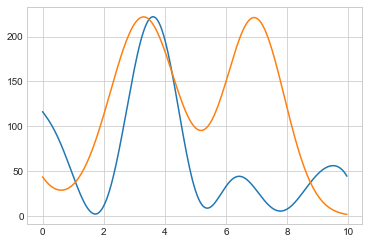

39th additional rbflayer
a: tensor([[-193.7156, -193.6049, -193.2556, -192.9113, -192.2427]],
       device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[7.1000],
        [7.1500],
        [7.0500],
        [7.2000],
        [7.0000]], device='cuda:0', dtype=torch.float64)
tensor([[-193.7156, -193.6049, -193.2556, -192.9113, -192.2427]],
       device='cuda:0', dtype=torch.float64)
tensor([[3.4116],
        [3.4145],
        [3.4090],
        [3.4175],
        [3.4065]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
39th additional RBFlayer 0th epoch loss: 326447.34163415903
tensor([[ -12.7409,  -13.5388,  -14.3805,  -15.2680,  -16.2033,  -17.1885,
          -18.2258,  -19.3174,  -20.4655,  -21.6727,  -22.9411,  -24.2734,
          -25.6720,  -27.1396,  -28.6787,  -30.2921,  -31.9826,  -33.7528,
          -35.6058,  -37.5444,  -39.5715,  -41.6902,  -43.9034,  -46.2143,
          -48.6260,  -51.1415,  -53.7641,  -56.4969,  -59.3432,  -62.3061,
  

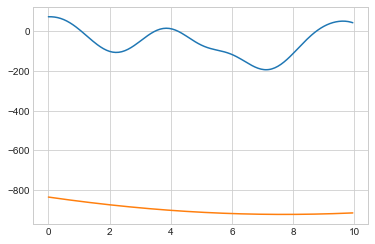

40th additional rbflayer
a: tensor([[966.7481, 966.6369, 966.5027, 966.1794, 965.8873, 965.3830, 964.8858,
         964.2527, 963.4788, 962.7913]], device='cuda:0', dtype=torch.float64)
additional parameters
tensor([[9.4500],
        [9.7500],
        [9.4000],
        [9.8000],
        [9.3500]], device='cuda:0', dtype=torch.float64)
tensor([[965.3830, 964.8858, 964.2527, 963.4788, 962.7913]], device='cuda:0',
       dtype=torch.float64)
tensor([[2.8987],
        [2.5304],
        [2.9728],
        [1.6019],
        [3.0402]], device='cuda:0', dtype=torch.float64)
----------------------
epoch : 0
40th additional RBFlayer 0th epoch loss: 3429391.8754212805
tensor([[1.4270e-01, 1.5842e-01, 1.7577e-01, 1.9491e-01, 2.1603e-01, 2.3930e-01,
         2.6495e-01, 2.9318e-01, 3.2425e-01, 3.5842e-01, 3.9597e-01, 4.3723e-01,
         4.8253e-01, 5.3223e-01, 5.8675e-01, 6.4650e-01, 7.1195e-01, 7.8361e-01,
         8.6203e-01, 9.4778e-01, 1.0415e+00, 1.1439e+00, 1.2557e+00, 1.3776e+00,
         1.

KeyboardInterrupt: 

In [38]:
model = MultiRBFnn2(single_target.size(0), 5, device)
model.train(input_, single_target, 5, 0.000001, 5, 100)

In [36]:
torch.tensor([[885.3070, 868.6752, 852.0175, 835.3485, 818.6829, 802.0361, 785.4237,
         768.8616, 752.3658, 735.9521]], device='cuda:0', dtype=torch.float64)[::,-5:]

tensor([[802.0361, 785.4237, 768.8616, 752.3658, 735.9521]], device='cuda:0',
       dtype=torch.float64)